In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/kidney_disease.csv')

df.head()

,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
0,71,0.30,40.9,0,1,46.8,1622.0,1,0
1,34,1.79,17.1,0,0,43.8,1428.0,1,0
2,80,2.67,15.0,0,1,78.2,1015.0,1,0
3,40,0.97,31.1,0,1,92.8,1276.0,1,0
4,43,2.05,22.8,1,1,62.2,1154.0,0,0


In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB
None


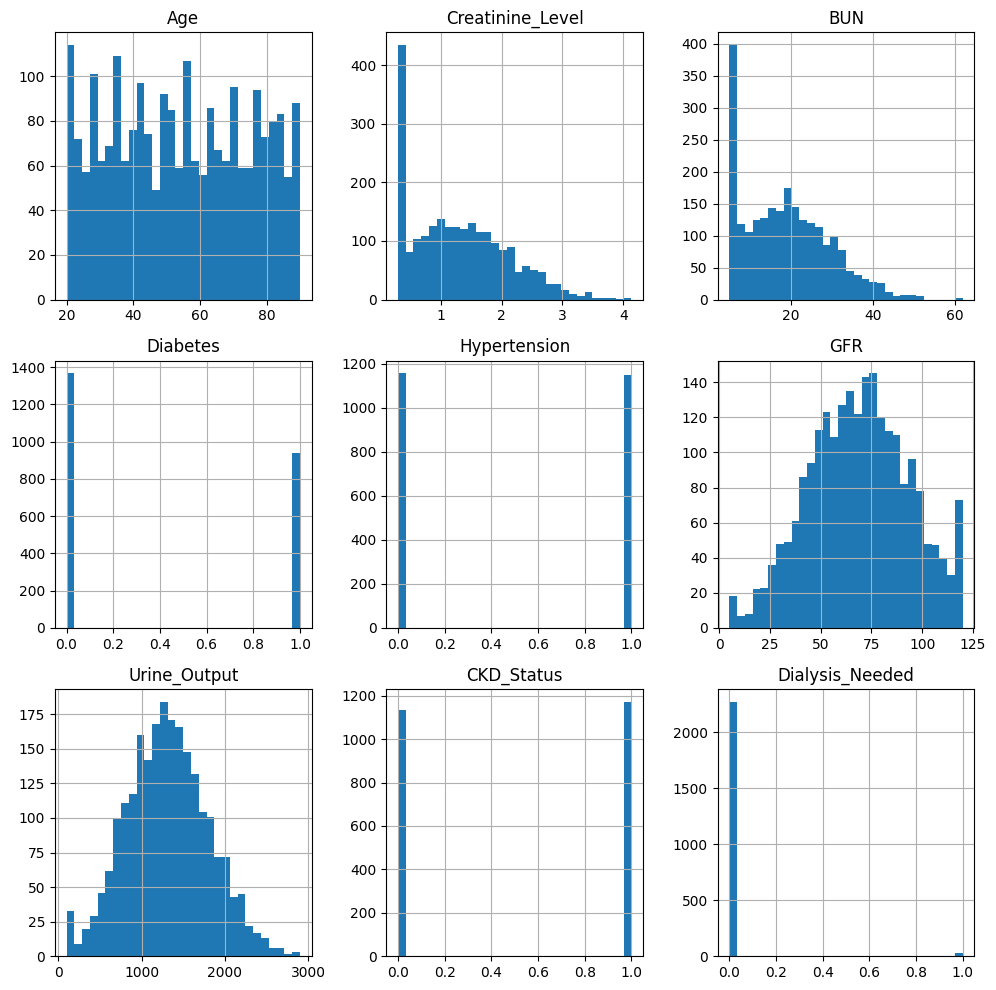

In [3]:
df.hist(bins=30,figsize=(10,10))
plt.tight_layout()
plt.show()

In [4]:
X = df.drop(['CKD_Status','Dialysis_Needed'],axis=1)
y = df['CKD_Status']

"""In my project, I want to predict kidney disease. So CKD_Status is my target. 
If I keep it in features, the model will cheat. Dialysis_Needed is not my target because dialysis is only needed when a person already has CKD. 
First, we need to find if the person has disease, then we can think about dialysis. 
That's why I dropped both from features and kept CKD_Status as y"""

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
#Model Training with GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20, 30],          
            'min_samples_split': [2, 5, 10],          
            'criterion': ['gini', 'entropy']          
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5]
        }
    }
}



In [11]:
best_models = {}
for name, config in models.items():
    print(f"\n🔍 Training {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best CV accuracy: {grid.best_score_:.4f}")
    
    # Test evaluation
    y_pred = grid.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_pred))


🔍 Training RandomForest...
Best parameters: {'max_depth': None, 'n_estimators': 100}
Best CV accuracy: 0.9995
Test accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       1.00      1.00      1.00       227

    accuracy                           1.00       461
   macro avg       1.00      1.00      1.00       461
weighted avg       1.00      1.00      1.00       461


🔍 Training DecisionTree...
Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best CV accuracy: 0.9995
Test accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       234
           1       1.00      1.00      1.00       227

    accuracy                           1.00       461
   macro avg       1.00      1.00      1.00       461
weighted avg       1.00      1.00      1.00       461


🔍 Training GradientBoosting...
Best parameters: {'learn

In [12]:
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Test Accuracy': acc})

results_df = pd.DataFrame(results)
print(results_df)

              Model  Test Accuracy
0      RandomForest            1.0
1      DecisionTree            1.0
2  GradientBoosting            1.0


In [14]:
patient = pd.DataFrame({
    'Age': [55],
    'Creatinine_Level': [2.5],
    'BUN': [35],
    'Diabetes': [1],
    'Hypertension': [1],
    'GFR': [30],
    'Urine_Output': [600]
})

print("Patient Data:")
print(patient)

# Scale and predict
patient_scaled = scaler.transform(patient)
pred = model.predict(patient_scaled)[0]
prob = model.predict_proba(patient_scaled)[0][1]

print(f"\n Prediction: {'CKD DETECTED' if pred == 1 else 'HEALTHY'}")
print(f" Probability of CKD: {prob:.2%}")

Patient Data:
   Age  Creatinine_Level  BUN  Diabetes  Hypertension  GFR  Urine_Output
0   55               2.5   35         1             1   30           600

 Prediction: CKD DETECTED
 Probability of CKD: 82.12%
